Assignment 9: Convolutional Auto-Encoder
========================================


Microsoft Forms Document: https://forms.office.com/r/ugv3L3jv8i

The task of this assignment is to compute a valuable deep feature representation for the handwritten digits of the MNIST dataset, without making use of their labels.
For this purpose, we implement a convolutional auto-encoder that learns a $K=10$-dimensional deep feature representation of each digit.
This representation can then be used to reconstruct images using the decoder part.

Task 1: Datasets
----------------

We will make use of the default implementations of the MNIST dataset.
As usual, we will need the training and validation set splits of MNIST, including data loaders.
The batches of the training set should be of size $B=32$, validation set batches should contain 100 samples.


In [1]:
import torch
import torchvision

# training set and data loader
train_set = torchvision.datasets.MNIST(root="./temp", train=True, download=True, transform=torchvision.transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_set, 32, shuffle=True)

# validation set and data loader
validation_set = torchvision.datasets.MNIST(root="./temp", train=False, download=True, transform=torchvision.transforms.ToTensor())
validation_loader = torch.utils.data.DataLoader(validation_set, 100)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./temp/MNIST/raw/train-images-idx3-ubyte.gz to ./temp/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./temp/MNIST/raw/train-labels-idx1-ubyte.gz to ./temp/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./temp/MNIST/raw/t10k-images-idx3-ubyte.gz to ./temp/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./temp/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./temp/MNIST/raw



Task 2: Encoder Network
-----------------------

For the encoder network, we will rely on a similar implementation from the last exercise, which is a convolutional network with two convolutional and one fully-connected layers.
The output of the encoder network determines the deep feature representation, which we will define to be $K=10$-dimensional.

There is one main difference to the network from Assignment 8, which is the way we perform our down sampling.
Instead of choosing a maximum pooling layer, we use a stride of 2 in our convolutions.
The ReLU activation function should be applied after each convolution.

对于编码器网络，我们将依靠上次练习中的类似实现，它是一个具有两个卷积层和一个全连接层的卷积网络。编码器网络的输出决定了深度特征表示，我们将把它定义为𝐾=10-维。

作业8中的网络有一个主要的区别，那就是我们执行向下采样的方式。我们没有选择最大集合层，而是在卷积中使用2的跨度。ReLU激活函数应该在每次卷积后应用。

In [2]:
class Encoder (torch.nn.Module):
  def __init__(self, Q1, Q2, K):
    # call base class constrcutor
    super(Encoder,self).__init__()
    # convolutional define layers
    self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=Q1, kernel_size=5, stride=2, padding=2)
    self.conv2 = torch.nn.Conv2d(in_channels=Q1, out_channels=Q2, kernel_size=5, stride=2, padding=2)
    # activation functions will be re-used for the different stages
    self.act = torch.nn.ReLU()
    # define fully-connected layers
    self.flatten = torch.nn.Flatten()
    self.fc = torch.nn.Linear(in_features=7*7*Q2, out_features=K)

  def forward(self, x):
    # get the deep feature representation
    x = self.act(self.conv1(x))
    x = self.act(self.conv2(x))
    x = self.flatten(x)
    deep_feature = self.fc(x)
    return deep_feature
from torchsummary import summary
model = Encoder(32,32,10).to("cuda")
summary(model,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]             832
              ReLU-2           [-1, 32, 14, 14]               0
            Conv2d-3             [-1, 32, 7, 7]          25,632
              ReLU-4             [-1, 32, 7, 7]               0
           Flatten-5                 [-1, 1568]               0
            Linear-6                   [-1, 10]          15,690
Total params: 42,154
Trainable params: 42,154
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.13
Params size (MB): 0.16
Estimated Total Size (MB): 0.30
----------------------------------------------------------------


Task 3: Decoder Network
-----------------------

The decoder network will obtain a deep feature representation as resulting from the encoder network.
It will learn to undo all the steps from the encoder, in order to produce an image that is of comparable size as the original images.
For this purpose, we require our decoder network to have:

* one fully-connected layer that produces the same number of outputs as are the input of the fully-connected layer of the encoder
* 一个全连接层，产生与编码器全连接层的输入相同数量的输出。
* we apply the ReLU activation function
* 我们应用ReLU激活函数
* then, the batch must be reshaped to the same dimensionality as the output of the `conv2` layer of the encoder
* 然后，批处理必须被重塑为与编码器的 "conv2 "层的输出相同的维度
* we apply a fractionally-strided convolution using the `torch.nn.ConvTranspose2d` that uses the same parameters as the `conv2` layer of the encoder; you might need to adapt the `output_padding`
* 我们使用 "torch.nn.ConvTranspose2d "进行分层卷积，它使用的参数与编码器的 "conv2 "层相同；你可能需要调整 "output_padding"。
* we apply the ReLU activation function
* 我们应用ReLU激活函数
* we apply a fractionally-strided convolution using the same parameters as the `conv1` layer of the encoder; `output_padding` might be required to be applied
* 我们应用分层卷积，使用与编码器的`conv1`层相同的参数；可能需要应用`output_padding`。

Finally, the goal is to have the output to be restricted between 0 and 1.
Think of possible ways of doing that, and apply the way that seems most reasonable.

最后，我们的目标是让输出被限制在0和1之间。
想一想可能的方法，并应用看起来最合理的方法。

Implement a network class that provides the required functionality.
Implement both a constructor `__init__` and a `forward` function.

<font color="#FF0000" font-weight="500">
<br>
OutSize = ( InSize − 1 ) × stride − 2 × padding + dilation × (kernel_size − 1) +  output_padding + 1 <br>
ps: dilation 默认为1 的情况下，简化一下 <br>
OutSize = ( InSize − 1 ) × stride − 2 × padding + kernel_size + output_padding
</font>


In [3]:
class Decoder (torch.nn.Module):
  def __init__(self, Q1, Q2, K):
    # call base class constrcutor
    super(Decoder,self).__init__()
    # fully-connected layer
    self.fc = torch.nn.Linear(in_features=K, out_features=Q2*7*7)
    # convolutional layers
        ### 为什么要增加output_padding???
    self.deconv1 = torch.nn.ConvTranspose2d(in_channels=Q2, out_channels=Q1, kernel_size=5, stride=2, padding=2, output_padding=1) 
    self.deconv2 = torch.nn.ConvTranspose2d(in_channels=Q1, out_channels=1, kernel_size=5, stride=2, padding=2, output_padding=1)
    # activation function
    self.act = torch.nn.ReLU()
    self.oact = torch.nn.Sigmoid()
    self.unflatten = torch.nn.Unflatten(dim=1,unflattened_size=(Q2,7,7)) ### nn.Unflatten(dim,unflattened_size) dim=1 是什么意思，因为第0个是batch size，所以得按照1来unfatten

  def forward(self, x):
    # reconstruct the output image
    x = self.act(self.fc(x))     ### 这儿为什么还有要一个 act？ (试过了，其实放在 unflatten 后也是一样的)
    # x = torch.reshape(x, (x.shape[0], self.deconv1.in_channels, 7, 7))   ### reshape 之后好像不能summary了……
    x = self.unflatten(x)
    x = self.act(self.deconv1(x))
    x = self.deconv2(x)           ### 这儿不需要act了！！！！！！ 很重要！！！！！！！ 不然train loop 学不到任何东西！
    output = self.oact(x)
    return output


Task 4: Joint Auto-Encoder Network
-----------------------------------

Implement an auto-encoder network that includes bot the encoder and the decoder.
Implement both a constructor `__init__` and a `forward` function.


In [4]:
class AutoEncoder(torch.nn.Module):
  def __init__(self, Q1, Q2, K):
    super(AutoEncoder,self).__init__()
    self.encoder = Encoder(Q1,Q2,K)
    self.decoder = Decoder(Q1,Q2,K)

  def forward(self,x):
    # encode input
    deep_feature = self.encoder(x)
    # decode to output
    reconstructed = self.decoder(deep_feature)
    return reconstructed

Test 1: Output Sizes
--------------------

Instantiate the auto-encoder network with $Q_1 = 32$, $Q_2 = 32$ and $K=10$.
Create an input $\mathbf X$ in the size that the `AutoEncoder` network requires.
Provide that input to the (untrained) encoder part of the auto-encoder network to extract the deep feature representation.
Check that the deep feature is in the desired size (K=10) 
Provide the deep feature to the (untrained) decoder part of the auto-encoder network.
Check that the output is of dimension $28\times28$, and its values are between 0 and 1.

In [5]:
# run on cuda device?
device = torch.device("cuda")
# create network
network = AutoEncoder(32,32,10).to(device)

# create or select a sample
sample = train_set[0][0].unsqueeze(0).to(device) ### (1,1,28,28)

# use encoder to encode image and check its size
deep_feature = network.encoder(sample)
assert deep_feature.shape == (1,10)

# use decoder to generate an image and check its size and value range
output = network.decoder(deep_feature)
print(output.shape)
assert output.shape == (1,1,28,28)
assert (output >= 0).all() and torch.all(output <= 1)

torch.Size([1, 1, 28, 28])


Task 5: Training Loop
---------------------

To train the auto-encoder network, we will use the $L_2$ distance between the output and the input of the network as a loss function.
This loss function is implemented in `torch.nn.MSELoss`.

Since training an auto-encoder is tricky, we will make use of the Adam optimizer.
Choose a learning rate of $\eta=0.001$.

Implement the training loop for 10 epochs.
Compute the average training loss and validation loss and print them at the end of each epoch.

Note: If the training and validation loss do not decrease during training, try to reduce the learning rate (to $\eta=0.0005$ or even lower) and re-start the training.
You will need to re-initialize the network, too, i.e. by re-running the previous cell.

In [6]:

# Adam optimizer with appropriate learning rate
optimizer = torch.optim.Adam(network.parameters(), lr=0.0005, weight_decay=1e-05)
loss = torch.nn.MSELoss()

for epoch in range(30):
  # evaluate average loss for training and validation set
  train_loss = validation_loss = 0.

  for x,_ in train_loader:
    optimizer.zero_grad()
    # compute network output
    x = x.to(device)
    y = network(x)
    # compute loss between output and input
    J = loss(y, x)
    # accumulate loss
    train_loss += J.item() * x.shape[0]  ### J.item() ??? 为什么不能 J.cpu() ### 并且这里的loss返回的是 batch 平均 loss
    # perform update
    J.backward()
    optimizer.step()

  # compute validation loss
  with torch.no_grad():
    for x,t in validation_loader:
      # compute network output
      x = x.to(device)
      y = network(x)
      # compute loss
      J = loss(y, x)
      # accumulate loss
      validation_loss += J.item() * x.shape[0]


  # print average loss for training and validation
  print(f"\rEpoch {epoch}; train: {train_loss/len(train_set):1.5f}, val: {validation_loss/len(validation_set):1.5f}")

Epoch 0; train: 0.04389, val: 0.02008
Epoch 1; train: 0.01873, val: 0.01717
Epoch 2; train: 0.01668, val: 0.01576
Epoch 3; train: 0.01557, val: 0.01499
Epoch 4; train: 0.01485, val: 0.01443
Epoch 5; train: 0.01434, val: 0.01405
Epoch 6; train: 0.01395, val: 0.01366
Epoch 7; train: 0.01367, val: 0.01347
Epoch 8; train: 0.01343, val: 0.01326
Epoch 9; train: 0.01326, val: 0.01306
Epoch 10; train: 0.01311, val: 0.01317
Epoch 11; train: 0.01299, val: 0.01285
Epoch 12; train: 0.01288, val: 0.01270
Epoch 13; train: 0.01278, val: 0.01279
Epoch 14; train: 0.01272, val: 0.01263
Epoch 15; train: 0.01265, val: 0.01257
Epoch 16; train: 0.01260, val: 0.01254
Epoch 17; train: 0.01253, val: 0.01257
Epoch 18; train: 0.01248, val: 0.01242
Epoch 19; train: 0.01245, val: 0.01252
Epoch 20; train: 0.01240, val: 0.01240
Epoch 21; train: 0.01237, val: 0.01244
Epoch 22; train: 0.01233, val: 0.01237
Epoch 23; train: 0.01229, val: 0.01231
Epoch 24; train: 0.01227, val: 0.01228
Epoch 25; train: 0.01224, val: 0.01

Task 6: Reconstruction Result
-----------------------------

Now we want to see if we can reconstruct images from their originals.
For this purpose, we select the first batch of our validation set images that contains 100 samples.
We forward this batch through our auto-encoder network and plot the reconstructed samples next to the original samples.

We will plot all the samples into a single plot, where we have 10 rows, each of which containing 10 pairs of original and reconstructed samples.

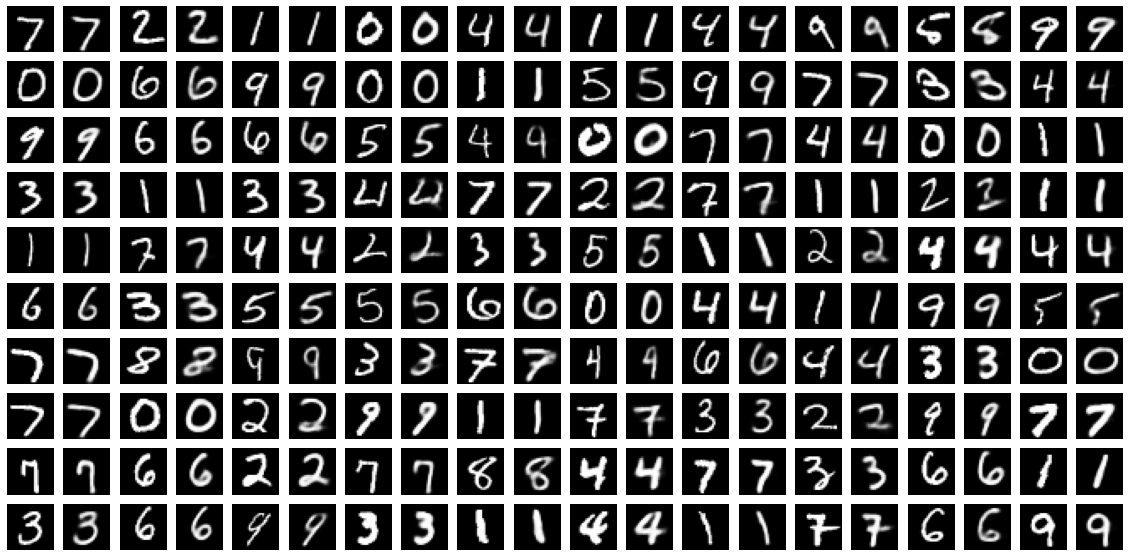

In [7]:
# get first validation set batch
input, _ = next(iter(validation_loader))

# compute outputs for all samples
with torch.no_grad():
  output = network(input.to(device)).cpu()

# plot images
from matplotlib import pyplot
pyplot.rcParams['image.cmap'] = 'gray'

pyplot.figure(figsize = (20,10))
for i in range(10):
  for j in range(10):
    pyplot.subplot(10, 20, i*20+2*j+1)
    pyplot.imshow(input[i*10 + j][0])
    pyplot.axis("off")
    pyplot.subplot(10, 20, i*20+2*j+2)
    pyplot.imshow(output[i*10 + j][0])
    pyplot.axis("off")

Task 7: Mean Vector per Class
-----------------------------

To see if the network has learned a reasonable representation for our 10 digits, we extract the mean deep feature vectors for each of the 10 classes.
We forward all samples of our validation set through the encoder part of our trained auto-encoder network, and compute a class-wise average of the deep features.

In [8]:
means = torch.zeros((10,10))
t_num = torch.zeros(10)

with torch.no_grad():
  # compute means
  for x, t in validation_loader:
    # extract deep features from encoder
    deep_features = network.encoder(x.to(device)).cpu() ### (batch_size, 10)
    # accumulate deep features for each class
    for df , t_ in zip(deep_features, t):
      t_num[t_] += 1
      means[t_] += df
    # for i, df in enumerate(deep_features):
    #   t_num[t[i]] += 1
    #   means[t[i]] += df

# compute means
means = means / t_num

assert means.shape == (10, 10)

Task 8: Decode Mixtures of Classes
----------------------------------

For each pair of class indexes, we compute the average of the deep feature representations of these two classes.
This results in a total of $10*10=100$ deep feature representations.

We use the decoder part of our trained auto-encoder network to reconstruct images from the deep feature representations.
We plot them in a grid of size $10*10$.
Note that the diagonal represents the reconstruction of the mean deep features for all classes, while non-diagonal elements show mixtures of two classes.

torch.Size([100, 10])


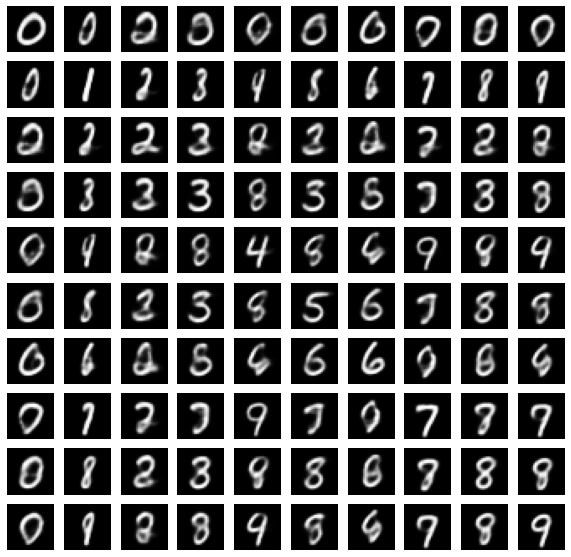

In [9]:
# compute mixtures of each two classes  


mixtures = torch.stack([(means[i] + means[j]) / 2 for i in range(10) for j in range(10)])
print(mixtures.shape)
# use network decoder to generate images
### Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead. !!!
images = network.decoder(mixtures.to(device)).detach().cpu().numpy() ### 如果需要梯度，是不能进行img的numpy计算的，要么 with torch.no_gard() 要么 detach().cpu().numpy()

pyplot.figure(figsize=(10,10))
#  and plot
for o1 in range(10):
  for o2 in range(10):
    pyplot.subplot(10,10,o1*10+o2+1)
    pyplot.imshow(images[o1*10 + o2][0])
    pyplot.axis("off")